# 台風発電船のスペック条件計算プログラム

### 最小スペック出力

硬翼帆かつツインタービンを搭載する台風発電船が台風下で運用可能なスペックを計算するプログラムです。

・発電時の船速は9m/s

・発電時の想定風速は25m/s(参考までに台風の暴風域が25m/s)

・波高の検討はしない

・横風の推進ができることを条件とする（風向40〜110度くらいで検討）

In [3]:
import numpy as np

### 風力推進機（硬翼帆）の推力計算

In [4]:
# 硬翼帆の揚力を推進力に利用する場合の計算用関数(26~167,193~333度の横風領域)(167~193度の向かい風)
def calculate_lift(air_density, wind_speed, sail_area, lift_coefficient):
    return 0.5 * air_density * wind_speed**2 * sail_area * lift_coefficient

def calculate_drag(air_density, wind_speed, sail_area, drag_coefficient):
    return 0.5 * air_density * wind_speed**2 * sail_area * drag_coefficient

def calculate_force(angle, lift, drag):

    #推力は船の進行方向が正、横力は進行方向右向きが正
    force_angle = np.radians(angle)
    force_side =  -lift * np.cos(force_angle) + drag * np.sin(force_angle)
    
    if angle <= 180:
        force_trust = lift * np.sin(force_angle) + drag * np.cos(force_angle)
    else:
        #硬翼帆は一回転させず進行方向に対して0から180度、0から-180度に動かすため推力は鏡写しで計算する必要がある
        force_angle = np.radians(360 - angle)
        force_trust = lift * np.sin(force_angle) + drag * np.cos(force_angle)

    return force_trust, force_side


# 硬翼帆の抗力を推進力に利用する場合の計算用関数(0~26,333~360度の追い風領域)
def calculate_plate_drag(wind_direction, drag):
    force =  drag
    force_trust = force * np.cos(np.radians(wind_direction))
    force_side = force * np.sin(np.radians(wind_direction))
    return force_trust , force_side


# 風向360度対応仕事量計算用関数
def calculate_work(ship_speed_mps,wind_direction, wind_speed, sail_area, sail_num):
    air_density = 1.225  # 空気密度 [kg/m^3]
    
    #風向きによって計算方法を分岐
    #横風
    if 26 <= wind_direction <= 167 or 193 <= wind_direction <= 333:
        lift_coefficient = 1.8
        drag_coefficient = 0.4
        lift = calculate_lift(air_density, wind_speed, sail_area, lift_coefficient) * sail_num
        drag = calculate_drag(air_density, wind_speed, sail_area, drag_coefficient) * sail_num
        force_trust, force_side = calculate_force(wind_direction, lift, drag)
    
    #追い風
    elif 0 <= wind_direction <= 26 or 333 <= wind_direction <= 360:
        drag_coefficient = 1.3
        drag = calculate_drag(air_density, wind_speed, sail_area, drag_coefficient) * sail_num
        force_trust, force_side = calculate_plate_drag(wind_direction, drag)
    
    #向かい風
    else:
        lift_coefficient = 0.5  # 揚力係数
        drag_coefficient = 0.1  # 抗力係数
        lift = calculate_lift(air_density, wind_speed, sail_area, lift_coefficient) * sail_num
        drag = calculate_drag(air_density, wind_speed, sail_area, drag_coefficient) * sail_num
        force_trust, force_side = calculate_force(wind_direction, lift, drag)

    # 今回は横力(force_side)を無視して推進力のみを計算
    
    #仕事量の計算
    wind_work = force_trust * ship_speed_mps

    return wind_work

## 潮流発電機による抵抗の計算

In [5]:
def calculate_generator_drag_work(turbine_num, ship_speed_mps, rated_power_output_GW, generator_efficiency):
    # 海水密度[kg/m^3]
    sea_water_density = 1025
    # タービン抵抗係数
    turbine_drag_coefficient = 0.3
    # 定格出力からタービン回転面積の逆算
    turbine_area = (rated_power_output_GW * (10**9)) / (turbine_num * 0.5 * sea_water_density * ship_speed_mps**3 * generator_efficiency)
    # タービン半径の提示
    turbine_radius = np.sqrt(turbine_area / np.pi)
    
    # タービン抵抗の計算
    turbine_drag = turbine_num * 0.5 * sea_water_density * ship_speed_mps**2 * turbine_area * turbine_drag_coefficient

    # タービン抵抗による仕事量の計算
    turbine_work = turbine_drag * ship_speed_mps

    return turbine_work


### 船体抵抗の計算

In [6]:
def cal_dwt(storage,storage_method):
    #載貨重量トンを算出する。単位はt。

    if storage_method == 1: #電気貯蔵
        #重量エネルギー密度1000Wh/kgの電池を使うこととする。
        dwt = storage/1000/1000


    elif storage_method == 2: #水素貯蔵
        #有機ハイドライドで水素を貯蔵することとする。
        dwt = storage/5000*0.0898/47.4

    else:
        print("cannot cal")
    

    return dwt
    

def ship_body_drag_work(max_speed_mps,storage,storage_method,body_num):
    #船速をm/sからktに変換
    max_speed_kt = max_speed_mps*1.94384

    dwt = cal_dwt(storage,storage_method)/body_num

    if storage_method == 1: #電気貯蔵
        #バルカー型
        k = 1.7
        power = k*(dwt**(2/3))*(max_speed_kt**3)*body_num

    elif storage_method == 2: #水素貯蔵
        #タンカー型
        k = 2.2
        power = k*(dwt**(2/3))*(max_speed_kt**3)*body_num
  
    else:
        print("cannot cal")
    
    return power

In [7]:
#　定方さん論文での船体抵抗計算
import math

def ship_body_drag_work_sadakata(max_speed_mps):
    #船の諸元
    Lpp = 266 #船長[m]
    S_wet = 13831 #浸水表面積[m^2]

    # 海水動粘度[m^2/s]
    nu = 1.188 * 10**(-6)
    #　海水密度[kg/m^3]
    rho = 1025

    #　レイノルズ数
    Rn = max_speed_mps * Lpp / nu
    #　フルード数
    Fr = max_speed_mps / math.sqrt(9.8 * Lpp)
    #print("Rn",Rn/10**9)
    #print("Fr",Fr)

    delta_Cf = 1.2 * 10**(-4)
    C_f0 = 0.075/(math.log10(Rn)-2)**2
    #print("C_f0",C_f0*10**3)

    Cr = 9.030 * 10**(-4) #剰余抵抗係数（定方さん修論p19）

    # 船体の全抵抗係数
    C_T = C_f0 + Cr + delta_Cf
    #print("C_T",C_T*10**3)

    # 船体抵抗の計算
    D = 0.5 * rho * max_speed_mps**2 * S_wet * C_T
    #print("D",D/1000)

    # 船体抵抗による仕事量の計算
    power = D * max_speed_mps

    return power



### スペック算出

In [8]:
#運航条件
ship_speed_mps = 9  # 船の速度 [kt]
wind_speed = 25  # 風速 [m/s]

# 例としてウィンドチャレンジャー帆の設定
sail_area = 880  # 帆面積 [m^2]
sail_num = 30 # 帆の数

# 潮流発電機の設定
turbine_num = 2  # タービンの数
rated_power_output_GW = 0.138  # 定格出力 [GW]
generator_efficiency = 0.3  # 発電機の効率

# 船体の設定
body_num = 1  # 船体の数
storage = 100*(10**9)  # 貯蔵量 [Wh]
# 載貨重量トンの提示
print("載貨重量トン:{}".format(cal_dwt(storage,2)))
storage_method = 2  # 貯蔵方法(1:電気貯蔵,2:水素貯蔵MCH)


# 風向40〜110度の場合の仕事量の計算
wind_directions = np.arange(40, 110, 1)  # [degrees]

#　各仕事量のリスト
wind_work_list = []
turbine_work_list = []
ship_body_drag_work_list = []
ship_body_drag_work_sadakata_list = []
total_work_list = []

for wind_direction in wind_directions:
    wind_work = calculate_work(ship_speed_mps, wind_direction, wind_speed, sail_area, sail_num)
    turbine_work = calculate_generator_drag_work(turbine_num, ship_speed_mps, rated_power_output_GW, generator_efficiency)
    ship_body_drag = ship_body_drag_work(ship_speed_mps,storage,storage_method,body_num)
    ship_body_drag_sadakata = ship_body_drag_work_sadakata(ship_speed_mps)
    wind_work_list.append(wind_work/10**6)
    turbine_work_list.append(turbine_work/10**6)
    ship_body_drag_work_list.append(ship_body_drag/10**6)
    ship_body_drag_work_sadakata_list.append(ship_body_drag_sadakata/10**6)
    if ship_body_drag + turbine_work - wind_work < 0:
        total_work_list.append(0)
    else:
        total_work_list.append((turbine_work + ship_body_drag - wind_work)/10**6)

# total_work_listの0になっているwind_directionの範囲を取得
zero_work_range = [wind_directions[i] for i, work in enumerate(total_work_list) if work == 0]
# 上記wind_directionの両端の数値を表示
if len(zero_work_range) == 0:
    print("台風下で理想運航ができません")
else:
    zero_work_range_start = zero_work_range[0]
    zero_work_range_end = zero_work_range[-1]
    print("風向{}度から{}度の間で台風下で理想運航が可能です".format(zero_work_range_start, zero_work_range_end))



載貨重量トン:37890.29535864979
風向52度から103度の間で台風下で理想運航が可能です


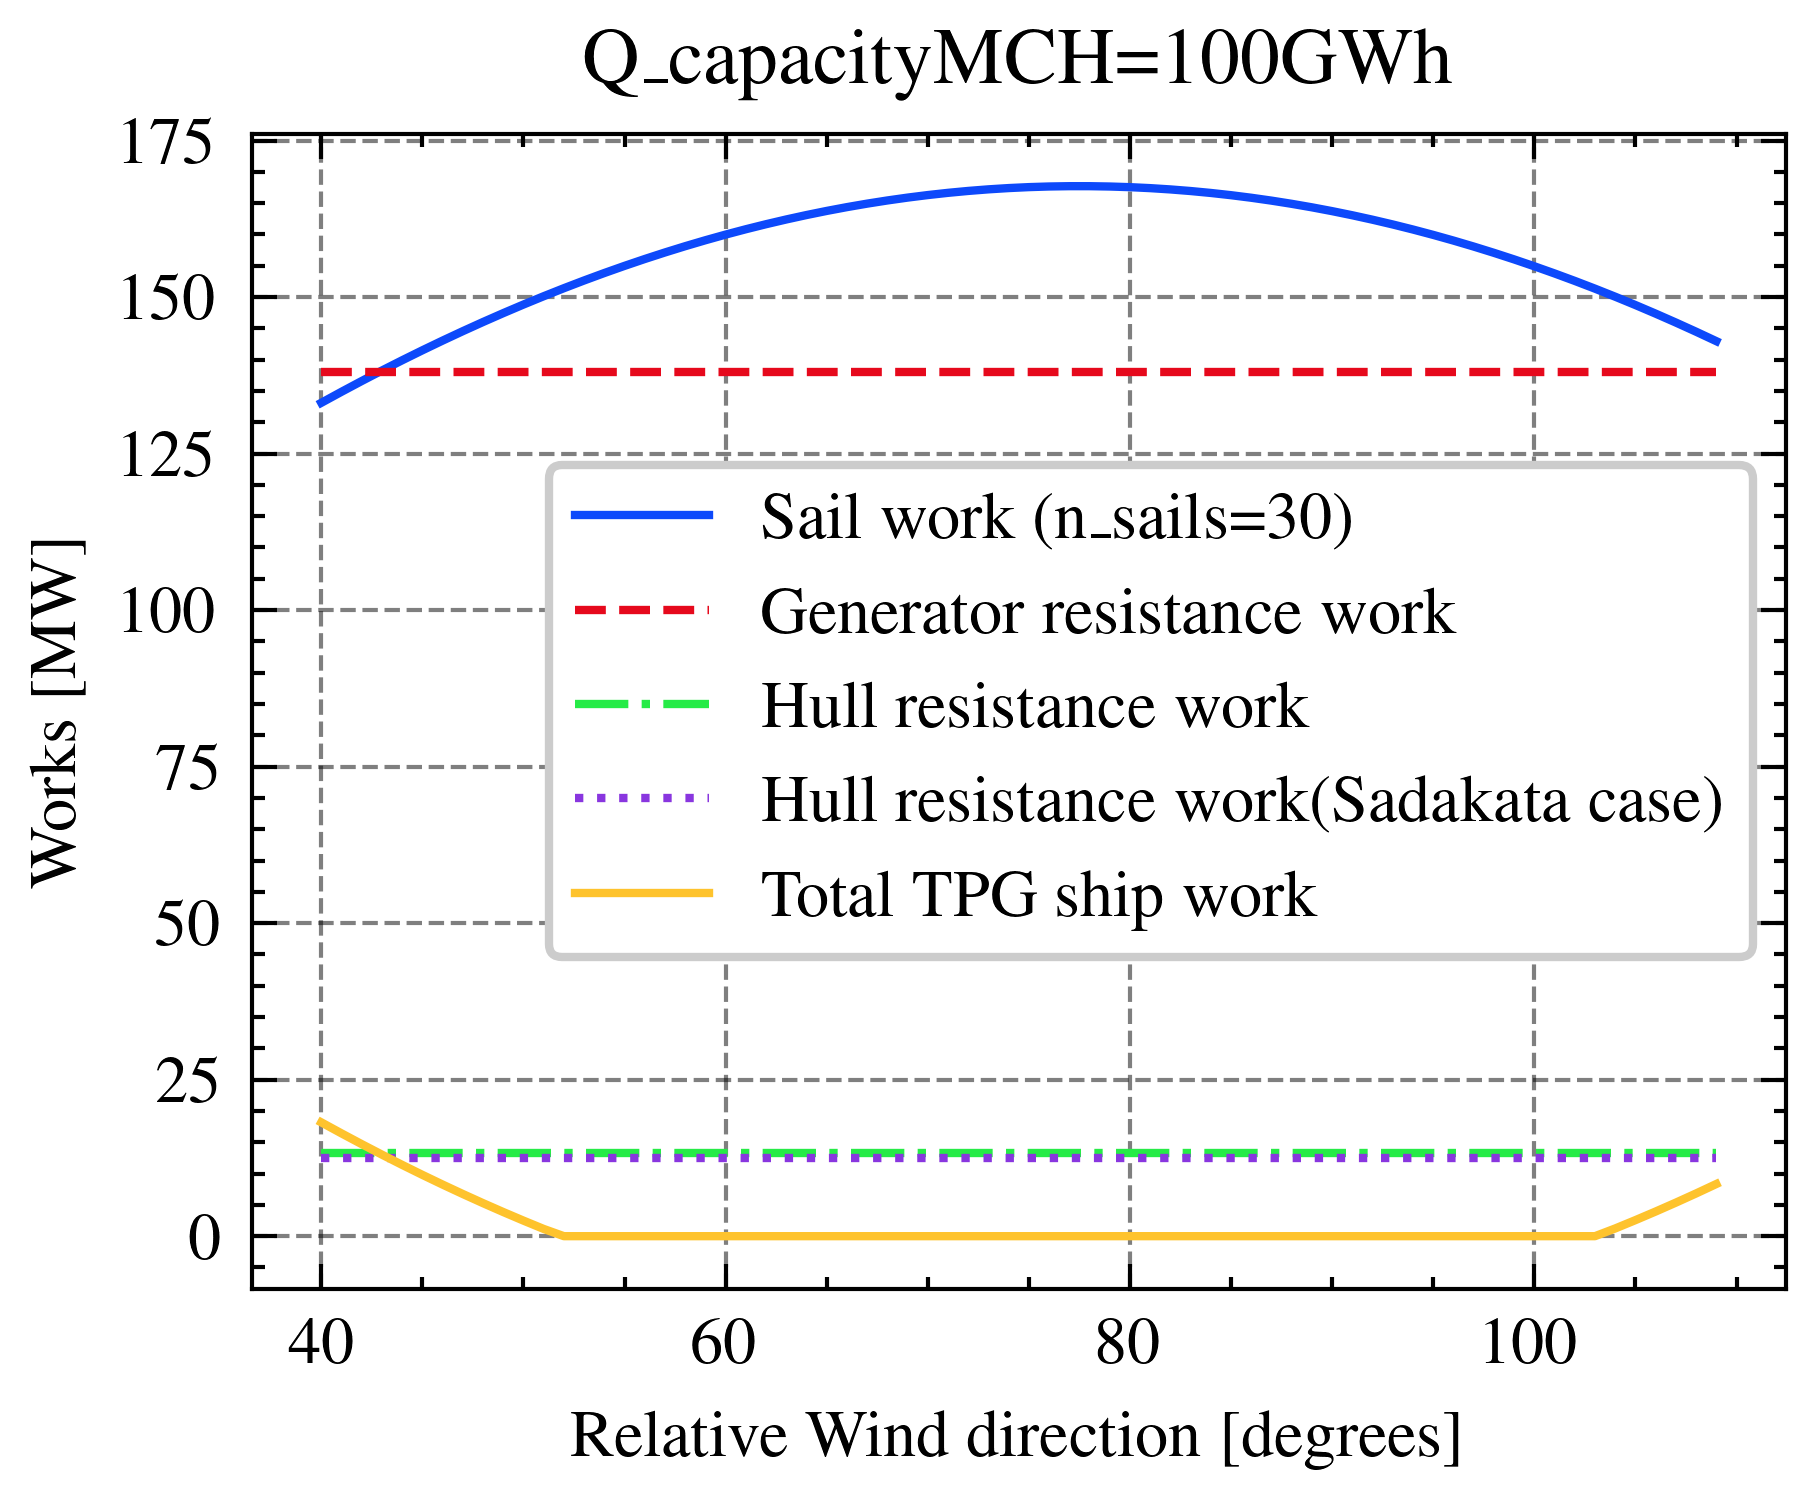

In [9]:
# 仕事量のグラフの描画
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','ieee','high-vis','grid'])

wind_work_label = 'Sail work (n_sails={})'.format(sail_num)
Title = 'Q_capacityMCH={}GWh'.format(int(storage/10**9))

plt.plot(wind_directions, wind_work_list, label=wind_work_label)
plt.plot(wind_directions, turbine_work_list, label='Generator resistance work')
plt.plot(wind_directions, ship_body_drag_work_list, label='Hull resistance work')
plt.plot(wind_directions, ship_body_drag_work_sadakata_list, label='Hull resistance work(Sadakata case)')
plt.plot(wind_directions, total_work_list, label='Total TPG ship work')
#タイトルラベル
plt.title(Title)

plt.xlabel('Relative Wind direction [degrees]')
plt.ylabel('Works [MW]')
plt.legend()
plt.show()
